# Single sentence training example

In [1]:
import sys
sys.path.append("../../my_lib/src/Quantum")
sys.path.append("../../my_lib/src/DataPreparation")

In [2]:

import pandas as pd
import json
import matplotlib.pyplot as plt

import random
import dictionary
import sentence
import Optimizer as optimizer
import loader
import Circuit as circuit

Creating the dictionary and sentence objects. We need to 

In [3]:
myDict = dictionary.QuantumDict(qn=1,#Number of qubits for noun category. 
                                qs=1)#Number of qubits for sentence category
                                     #For qn or qs>1 time increases considerably
mySentence = sentence.Sentence("dog barking at cat",#Sentence string
                               dictionary=myDict,
                               stype=1,#Sentence structure. 1 corresponds to NOUN-IVERB-PREP-NOUN
                               label=0)#Truth Value -> 0:False, 1:True

In [4]:
print('MySentence is a Sentence object with the following properties required to build and train the quantum circuit:\n')
print('Word categories: \n {} \n'.format(mySentence.categoriesarray))
print('The number of qubits used per category:  \n {} \n'.format(mySentence.categoriesarray))
print('A QuantumDict object with qn, qs and the word used:  \n {} \n'.format(mySentence.dictionary))
print('The sentence truth value:  \n {} \n'.format(mySentence.label))
print('The number of qubits needed for the sentence structured for each word:  \n {} \n'.format(mySentence.qubitsarray))
print('The sentence structure code:  \n {} \n'.format(mySentence.stype))

MySentence is a Sentence object with the following properties required to build and train the quantum circuit:

Word categories: 
 [['n'], ['nr', 's'], ['sr', 'nrr', 'nr', 's', 'nl'], ['n']] 

The number of qubits used per category:  
 [['n'], ['nr', 's'], ['sr', 'nrr', 'nr', 's', 'nl'], ['n']] 

A QuantumDict object with qn, qs and the word used:  

The sentence truth value:  
 0 

The number of qubits needed for the sentence structured for each word:  
 [[0], [1, 2], [3, 4, 5, 6, 7], [8]] 

The sentence structure code:  
 1 



Now the qubit contractions are found for the given sentence structure

In [5]:
mySentence.getqbitcontractions()#Searchs for the qubit contractions needed acording to qn, 
                                #qs, and sentence type
    
myCircBuilder = circuit.CircuitBuilder()
mySentence.setsentenceparameters()#If nothing is specified, random parameters will be
                                  #generated for the contractions

The following array has been created using the mapping from word to categories provided in the dictionary object and the rules for the contractions given by the sentence type. The qubit carrying the meaning of the sentence is qubit 6, which is only a qubit because qs=1 by default and is the only one not appearing in the contractions array

In [6]:
for contraction in mySentence.contractions:
    print(contraction)

[array([0]), array([5])]
[array([1]), array([4])]
[array([2]), array([3])]
[array([7]), array([8])]


We run the circuit with the initial random parameters. In this case, sentence label is 0, so we are interested in the first quantum state.

### Creating the original sentence circuit

Here we are running the circuit with the random initial parameters. In this case, we are interested in the result from the 6th qubit, as we stated above. The rest of qubits are projected to 0 in post-selection. This way, we get a value between 0 and 1 that we can use as a cost function to train the circuit. 
The probabilities of the two possible states are then properly normalized to sum 1.

-----
For creating the sentences the following ansatz was used.
* qn = 1
* qs = 1

More qubits are shown for better understanding of Ansatz shape
<img src="SentenceAnsatz.png">

In [7]:
myCircBuilder.createcircuit(mySentence)#Creates a QLM Program() object with the information 
                                       #from the sentence
myCircBuilder.executecircuit()#Writes the result of executing the circuit as a 
                              #myCircBuilder attribute
probs = []
for sample in myCircBuilder.result:
    #An iteration through the samples to apply post selection and record the 
    #probability of getting |00...0(qs=0)00...00> and |00...0(qs=1)00...00> states.
    state = sample.state.bitstring
    postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != mySentence.sentencequbit)
    if postselectedqubits == '0' * (myCircBuilder.qlmprogram.qbit_count - 1):
        probs.append(sample.probability)
        print("State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
params = mySentence.getparameters()
flat_params0 = [item for sublist in params for item in sublist]
initialfalseprob = probs[0] / sum(probs)
print('\n')
print('Probability of sentence being False (qubit output = 0: ', probs[0] / sum(probs))
print('Probability of sentence being True (qubit output = 1: ', probs[1] / sum(probs))

State |000000000>: probability 0.0018932996254356306, amplitude (-0.04236123499469151-0.009941096275570114j)
State |000000100>: probability 0.0019803923565395007, amplitude (0.033735675601511125+0.0290223456710361j)


Probability of sentence being False (qubit output = 0:  0.4887584336197708
Probability of sentence being True (qubit output = 1:  0.5112415663802292


We get the parameters from the sentence and flattern them to feed the optimizer

In [8]:
#We flattern the pararms as they are formatted and separated per word
params=mySentence.getparameters()
flat_params0 = [item for sublist in params for item in sublist]

### Optimizing the circuit

We print the cost function with the initial parameters.
Then, the optimized values are stored in resultparams. 
We need to reshape those params so we can use them for preparing the circuit again.
COBYLA optimizer is used in this example

In [9]:
myOptimizer = optimizer.ClassicalOptimizer()

resultparams = myOptimizer.optimizesentence(mySentence,#Sentence object to be trained
                                            tol=1e-2,#SciPy param, trust-interval related
                                            options={'maxiter':100, 'rhobeg': 0.1},#Scipy params, 
                                                                            #max number of iterations
                                                                            #and reasonable step
                                            method="COBYLA")#Optimization method
resultreshaped = myOptimizer.reshapeparams(resultparams.x, mySentence)
print('original params:', params)
print('best params:', resultreshaped)

iteration 10 
 Cost: 0.5953417059536116
iteration 20 
 Cost: 0.38316627483513177
iteration 30 
 Cost: 0.1134192719477812
iteration 40 
 Cost: 0.030818383182985843
iteration 50 
 Cost: 0.0012894737043841775
iteration 60 
 Cost: 0.0002696104704864438
iteration 70 
 Cost: 7.419630183719722e-05
iteration 80 
 Cost: 0.00011077515338782858
iteration 90 
 Cost: 9.097710619248762e-05
iteration 100 
 Cost: 8.310721737590933e-06
original params: [[0.5982278757977051, 2.6639075506164662], [1.7343690708195572, 0.8439600712386546, 4.522156933424671, 5.199466346006099], [3.270627145662187, 5.250288558301309, 1.109710430653931, 4.3446387027050655, 6.142097865719639, 4.825034062503735, 4.246181116832625, 5.796003642487488, 4.024183832649868, 4.233001247870628], [5.263126979736716, 2.343137885759578]]
best params: [[0.7862782916015219, 2.8910829296293103], [1.9314939939325335, 1.2808385433397753, 4.950604357521454, 4.927488960638536], [3.623349322994782, 5.249024433356663, 0.8172342151834443, 3.9578066

Text(0, 0.5, 'Cost function (Cross entropy)')

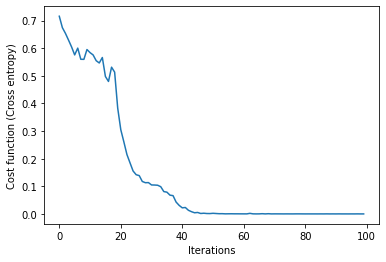

In [10]:
plt.plot(myOptimizer.itercost)
plt.xlabel('Iterations')
plt.ylabel('Cost function (Cross entropy)')

We run the circuit again with the optimized parameters and see how the truth value is satisfied and the cost function has been minimized. We see that the probability of the quantum output being compliant with the original label increases dramatically.

In [11]:
myCircBuilderifnal = circuit.CircuitBuilder()
mySentence.setsentenceparameters(randompar=False, params=resultreshaped)
myCircBuilderifnal.createcircuit(mySentence)
myCircBuilderifnal.executecircuit()

probs = []
for sample in myCircBuilderifnal.result:
    state = sample.state.bitstring
    postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != mySentence.sentencequbit)
    if postselectedqubits == '0' * (myCircBuilderifnal.qlmprogram.qbit_count - 1):
        probs.append(sample.probability)
print('Original probability of sentence being False: {}'.format(initialfalseprob))
print('Trained probaility of sentence being False: {}'.format(probs[0] / sum(probs)))

Original probability of sentence being False: 0.4887584336197708
Trained probaility of sentence being False: 0.9999964586903973
